In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Setup

In [3]:
basedir = "../../"
import sys, os
from astropy.table import Table, vstack
from astropy.io import fits

for subdir in [""]:
    sys.path.append(basedir+subdir)
from misc import *
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import json
from scipy.special     import erfc

sys.path.append('..')
from mc_forecast import mc_forecast
from forecast_utils import *

In [4]:
from matplotlib.pyplot import rc
rc('mathtext', **{'fontset':'cm'})
import matplotlib
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams["font.family"] = "serif"


In [5]:
m_bands = ['M411','M438','M464','M490','M517']
band_z = {
    'M411':[2.26,2.56],
    'M438':[2.47,2.77],
    'M464':[2.68,2.98],
    'M490':[2.89,3.2],
    'M517':[3.1,3.41]
}

In [6]:
cosmo = get_cosmo_P18()
h = cosmo.h()

In [8]:
fint_list = np.loadtxt(basedir+'data_measurements/fint_v4/pessimistic.txt')
fint_list += np.loadtxt(basedir+'data_measurements/fint_v4/optimistic.txt')
fint_list /= 2

fn = basedir+'data_measurements/wR_v4/lae_5bins.json'
data = json.load(open(fn,'r'))

datwt_array = []
for j, band in enumerate(m_bands):
    fint = fint_list[j]    
    datwt_array.append(np.array(data['z%d'%(j+1)]['wt']) / (1-fint)**2)
datwt_array = np.array(datwt_array)

### Loading the data catalog (unnecessary to just produce plots)

In [8]:
fn = "/pscratch/sd/h/hebina/IBIS/selection_clustering/catalogs/clustering_cat_v4.fits"
# fn = "/global/cfs/cdirs/desi/users/raichoor/laelbg/ibis/analysis/daily-tmp/ibis-xmm-ar-djs-he-rr.fits"
d = Table.read(fn)
radius = 1.4
ra0,dec0 = 35.75, -4.75
area = 1.4**2 * np.pi
coord_cut = angular_distance(d['RA'],d['DEC'],ra0,dec0)<radius
d = d[coord_cut]

fn = "/pscratch/sd/h/hebina/IBIS/selection_clustering/catalogs/redshift_cat_v4.fits"
# fn = "/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto/ibis-xmm-ar-djs-he-rr.fits"
d_spec = Table.read(fn)
radius = 1.4
ra0,dec0 = 35.75, -4.75
area = 1.4**2 * np.pi
coord_cut = angular_distance(d_spec['RA'],d_spec['DEC'],ra0,dec0)<radius
d_spec = d_spec[coord_cut]

In [9]:
use_mask = True

# $\chi^2$ fits

In [10]:
rbins = np.geomspace(0.4,45,9)[:-1]
RwR = np.sqrt(rbins[1:]*rbins[:-1])
lgMc_list = [11.00,11.25,11.50,11.75,12.0]
# lgMc_list += [11.3,11.4,11.6,11.7,11.8,11.9]
# sigm_list = [.33,.5,.66]#,1.]
alph_list = [.33,.66]#,1.]
sigm_list = [.33,.66]#,1.]
kapp_list = [1]
# plat_list = [5,10,30,100]
plat_list = [10,30,100]

Q_list = [20,100]
gamma_list = [1,5]
pm_list = [.33,.66]
chi2_arr = []
hod_arr = []
r0_arr = []
fsat_arr = []

fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/hod/large_grid_ELG_c000_ph100_z3.0_r.json'
lae = json.load(open(fn,"r"))

for lgMcut in lgMc_list:
  for plateau in plat_list:
    lgM1 = lgMcut + np.log10(plateau)
    for alph in alph_list:
      for sigm in sigm_list:
        for kappa in kapp_list:
          for Q in Q_list:
            for gamma in gamma_list:
                for pmax in pm_list:
                  hod_params = {'logM_cut':lgMcut,'logM1':lgM1,'sigma':sigm,'kappa':kappa,'alpha':alph,
                               'Q':Q,'gamma':gamma,'p_max':pmax}           
                  forecast = mc_forecast.initialize('ibis_tertiary44_clustering_v4.2',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                                           band_z['M411'][0], band_z['M517'][1], hod_params, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                                           m_bands=['M464','M490','M517'],zbox=3.0,gal_type='ELG')
                  assert forecast.check_hod_exists()
                  # forecast.make_cat(overwrite=False)
                  forecast.compute_wR(overwrite=False)
                  c2, tmp1, tmp2, _ = forecast.chi2_wR(datwt_array[2:])
                  hod_arr.append(hod_params)
                  chi2_arr.append(c2)
                  rr = lae['R']
                  for i,samp in enumerate(lae['mocks']):
                      tmp = True
                      for pp in hod_params.keys():
                          ppidx = lae['hodkeys'].index(pp)
                          tmp &= hod_params[pp]==samp['hod'][ppidx]
                      if tmp: break
                  if tmp==False: print(hod_params)
                  xi = np.array(samp['xi0'])
                  r0_arr.append(5*interp1d(rr,xi)(5)**(1/1.8))
                  fsat_arr.append(samp['fsat'])
                  del lae['mocks'][i]

wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed


In [11]:
chi2_arr_z2 = chi2_arr
r0_arr_z2 = r0_arr

In [12]:
bestfit_dict = {'z2':{'z':3.0,
                      'r0':r0_arr_z2,
                      'chi2':chi2_arr_z2,
                      'hod':hod_arr,
                      'fsat':fsat_arr,
                     },
               }
import json
with open('r0_arr_ELG.json', 'w') as fp:
    json.dump(bestfit_dict, fp)


In [14]:
r0_arr_z2[np.argmin(chi2_arr_z2)], hod_arr[np.argmin(chi2_arr_z2)], fsat_arr[np.argmin(chi2_arr_z2)]

(3.802096971340415,
 {'logM_cut': 11.0,
  'logM1': 13.0,
  'sigma': 0.33,
  'kappa': 1,
  'alpha': 0.66,
  'Q': 100,
  'gamma': 5,
  'p_max': 0.66},
 0.05971554674674617)

# Final figures

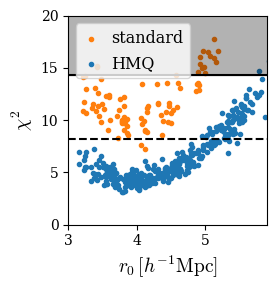

In [9]:
fig,axs = plt.subplots(1,1,figsize=(3,3))
ax = axs
for i in range(2):
    if i==0: fn = basedir+'mc/ibis_tertiary44_v4.2/r0_arr_ELG.json'
    else: fn = basedir+'mc/ibis_tertiary44_v4.2/r0_arr.json'
    dd = json.load(open(fn,'r'))
    # ax = axs[0]
    ax.scatter(dd['z2']['r0'],dd['z2']['chi2'],marker='.')
    # ax.scatter(dd['z2']['r0'],dd['z2']['chi2'],marker='.')
    ax.set_xlabel(r'$r_0\,[h^{-1}\text{Mpc}]$',fontsize=14)

ax.set_xlim(3.,5.9)
ax.set_ylim(0,20)
# ax.grid(alpha=.8,ls='--')

ax.axhline(8.18,c='k',ls='--')
ax.axhline(14.34,c='k',ls='-')
ax.fill_between(np.linspace(2,7),14.34, 30,color='k',alpha=.3)

ax.set_ylabel(r'$\chi^2$',fontsize=14)
ax.scatter([],[],c='C1',label=r'standard',marker='.')
ax.scatter([],[],c='C0',label=r'HMQ',marker='.')
ax.legend(loc='upper left',fontsize=11.5,handlelength=1)

fig.tight_layout()
# fig.savefig('plots/r0_chi2_ELG.pdf')
fig.show()